In [1]:
sentences = [['我 爱 学习 人工智能', '<sos> I love studying AI', 'I love studying AI <eos>'],
             ['深度学习 改变 世界', '<sos> DL changed the world', 'DL changed the world <eos>'],
             ['自然 语言 处理 很 强大', '<sos> NLP is so powerful', 'NLP is so powerful <eos>'],
             ['神经网络 非常 复杂', '<sos> Neural-Nets are complex', 'Neural-Nets are complex <eos>']
             ]
word_list_cn, word_list_en = [], []
for s in sentences:
    word_list_cn.extend(s[0].split())
    word_list_en.extend(s[1].split())
    word_list_en.extend(s[2].split())

word_list_cn = list(set(word_list_cn))
word_list_en = list(set(word_list_en))

word2idx_cn = {word: idx for idx, word in enumerate(word_list_cn)}
word2idx_en = {word: idx for idx, word in enumerate(word_list_en)}

idx2word_cn = {idx: word for idx, word in enumerate(word_list_cn)}
idx2word_en = {idx: word for idx, word in enumerate(word_list_en)}

voc_size_cn = len(word_list_cn)
voc_size_en = len(word_list_en)
print('The count of sentence: ', len(sentences))
print('Chinese vocabulary size: ', voc_size_cn)
print('English vocabulary size: ', voc_size_en)
print('Chinese word to idx dictionary: ', word2idx_cn)
print('English word to idx dictionary: ', word2idx_en)

The count of sentence:  4
Chinese vocabulary size:  15
English vocabulary size:  17
Chinese word to idx dictionary:  {'强大': 0, '深度学习': 1, '世界': 2, '改变': 3, '自然': 4, '非常': 5, '复杂': 6, '人工智能': 7, '学习': 8, '处理': 9, '很': 10, '神经网络': 11, '爱': 12, '我': 13, '语言': 14}
English word to idx dictionary:  {'AI': 0, 'studying': 1, 'world': 2, 'NLP': 3, '<eos>': 4, 'DL': 5, 'is': 6, 'Neural-Nets': 7, 'powerful': 8, 'love': 9, 'I': 10, 'so': 11, 'changed': 12, 'are': 13, 'complex': 14, '<sos>': 15, 'the': 16}


In [2]:
import numpy as np
import torch
import random

def make_data(sentences):
    random_sentence = random.choice(sentences)
    encoder_input = np.array([[word2idx_cn[word] for word in random_sentence[0].split()]])
    decoder_input = np.array([[word2idx_en[word] for word in random_sentence[1].split()]])
    target = np.array([[word2idx_en[word] for word in random_sentence[2].split()]])
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input)
    target = torch.LongTensor(target)
    return encoder_input, decoder_input, target

encoder_input, decoder_input, target = make_data(sentences)
for s in sentences:
    if all([word2idx_cn[w] in encoder_input[0] for w in s[0].split()]):
        original_sentence = s
        break
print("原始句子：", original_sentence)
print("编码器输入张量形状：", encoder_input.shape)
print("解码器输入张量形状：", decoder_input.shape)
print("目标张量的形状：", target.shape)
print("编码器输入张量：", encoder_input)
print("解码器输入张量：", decoder_input)
print("目标张量：", target)

原始句子： ['深度学习 改变 世界', '<sos> DL changed the world', 'DL changed the world <eos>']
编码器输入张量形状： torch.Size([1, 3])
解码器输入张量形状： torch.Size([1, 5])
目标张量的形状： torch.Size([1, 5])
编码器输入张量： tensor([[1, 3, 2]])
解码器输入张量： tensor([[15,  5, 12, 16,  2]])
目标张量： tensor([[ 5, 12, 16,  2,  4]])


In [3]:
import torch.nn as nn
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, decoder_context, encoder_context):
        scores = torch.matmul(decoder_context, encoder_context.transpose(-2, -1))
        attn_weights = nn.functional.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, encoder_context)
        return context, attn_weights


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        # self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True, bidirectional=True)
    
    def forward(self, inputs, hidden):
        embedded = self.embedding(inputs)
        output, hidden = self.rnn(embedded)
        return output, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.attention = Attention()
        # self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.out = nn.Linear(2*hidden_size, output_size)
        # self.out = nn.Linear(2*hidden_size, output_size)

    def forward(self, inputs, hidden, enc_outputs):
        embedded = self.embedding(inputs)
        output, hidden = self.rnn(embedded, hidden)
        context, attn_wights = self.attention(output, enc_outputs)
        dec_output = torch.cat((output, context), dim=-1)
        dec_output = self.out(dec_output)
        return dec_output, hidden, attn_wights

n_hidden = 128
encoder = Encoder(voc_size_cn, n_hidden)
decoder = Decoder(voc_size_en, n_hidden)
print("Encoder architecture: ", encoder)
print("Decoder architecture: ", decoder)



Encoder architecture:  Encoder(
  (embedding): Embedding(15, 128)
  (rnn): RNN(128, 128, batch_first=True)
)
Decoder architecture:  Decoder(
  (embedding): Embedding(17, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (attention): Attention()
  (out): Linear(in_features=256, out_features=17, bias=True)
)


In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_input, hidden, dec_input):
        encoder_output, encoder_hidden = self.encoder(enc_input, hidden)
        decoder_hidden = encoder_hidden
        decoder_output, _, attn_weights = self.decoder(dec_input, decoder_hidden, encoder_output)
        return decoder_output, attn_weights
model = Seq2Seq(encoder, decoder)
print("S2S模型结构：", model)

S2S模型结构： Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(15, 128)
    (rnn): RNN(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(17, 128)
    (rnn): RNN(128, 128, batch_first=True)
    (attention): Attention()
    (out): Linear(in_features=256, out_features=17, bias=True)
  )
)


Epoch: 0040 cost = 0.319427
Epoch: 0080 cost = 0.028139
Epoch: 0120 cost = 0.016548
Epoch: 0160 cost = 0.009082
Epoch: 0200 cost = 0.006648
Epoch: 0240 cost = 0.005839
Epoch: 0280 cost = 0.003543
Epoch: 0320 cost = 0.003785
Epoch: 0360 cost = 0.003347
Epoch: 0400 cost = 0.002901


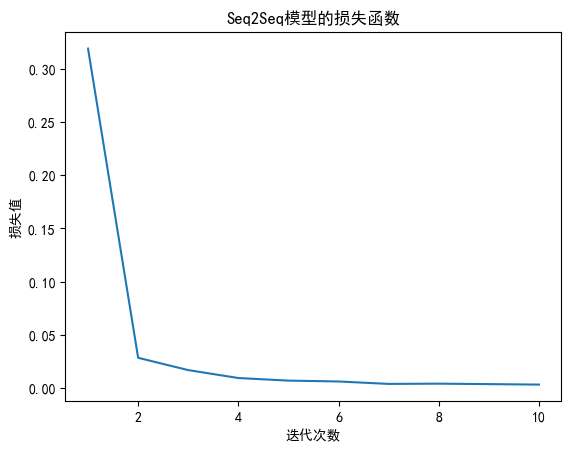

In [5]:
def train_seq2seq(model, criterion, optimizer, epochs):
    losses = []
    for epoch in range(epochs):
        encoder_input, decoder_input, target = make_data(sentences)
        hidden = torch.zeros(1, encoder_input.size(0), n_hidden)
        optimizer.zero_grad()
        output, _ = model(encoder_input, hidden, decoder_input)
        loss = criterion(output.view(-1, voc_size_en), target.view(-1))
        if (epoch+1) % 40 == 0:
            print(f"Epoch: {epoch + 1:04d} cost = {loss:.6f}")
            losses.append(loss.item())
        loss.backward()
        optimizer.step()

    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = ['SimHei']
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(range(1, 400//40 + 1), losses)
    plt.title('Seq2Seq模型的损失函数')
    plt.xlabel('迭代次数')
    plt.ylabel('损失值')
    plt.show()

epochs = 400
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_seq2seq(model, criterion, optimizer, epochs)


我 爱 学习 人工智能 -> ['I', 'I', 'studying', 'AI']


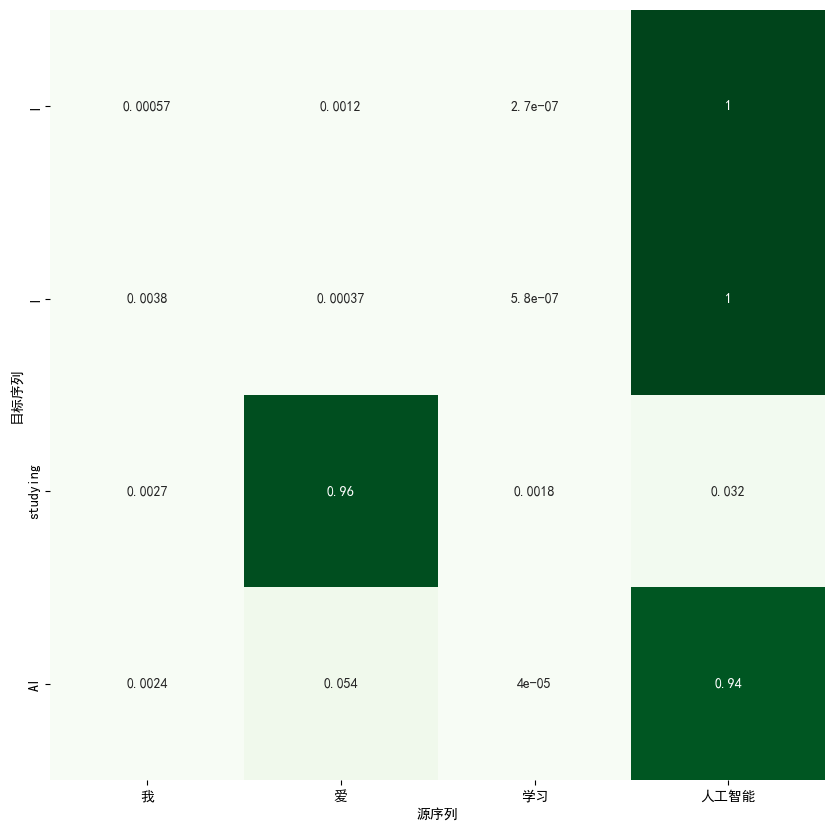

自然 语言 处理 很 强大 -> ['NLP', 'is', 'so', 'so', 'is']


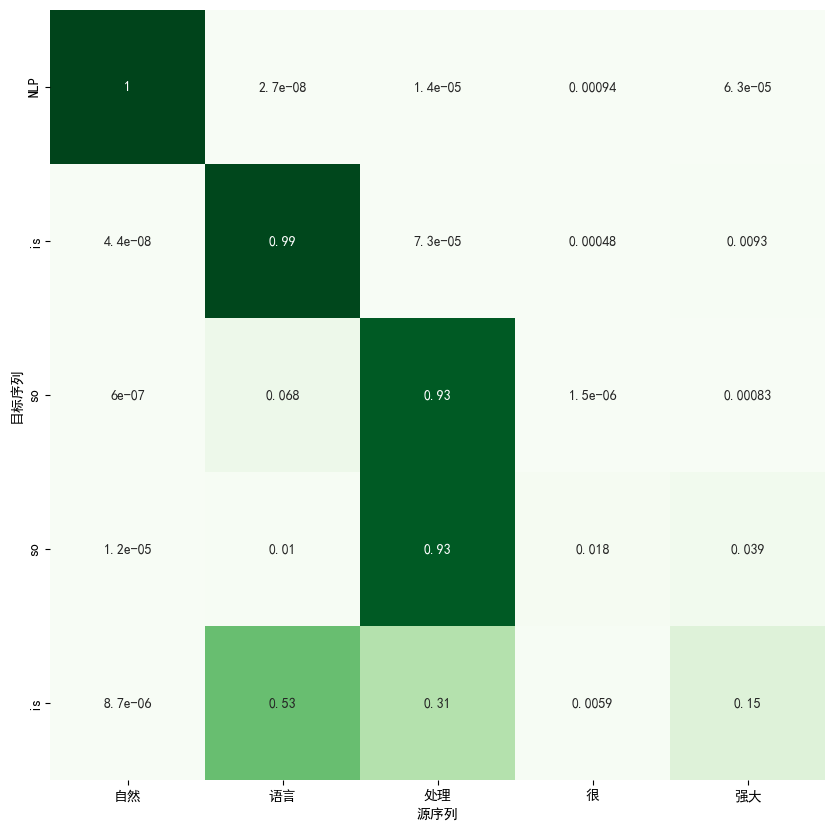

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"]=["SimHei"]
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False
def visualize_attention(source_sentence, predicted_sentence, attn_weights):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(attn_weights, annot=True, cbar=False,
                     xticklabels=source_sentence.split(),
                     yticklabels=predicted_sentence, cmap="Greens")
    plt.xlabel("源序列")
    plt.ylabel("目标序列")
    plt.show()

def test_seq2seq(model, source_sentence):
    encoder_input = np.array([[word2idx_cn[n] for n in source_sentence.split()]])
    decoder_input = np.array([word2idx_en['<sos>']] + [word2idx_en['<eos>']]*(len(encoder_input[0])-1))
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input).unsqueeze(0)
    hidden = torch.zeros(1, encoder_input.size(0), n_hidden)
    predict, attn_weights = model(encoder_input, hidden, decoder_input)
    predict = predict.max(2, keepdim=True)[1]
    print(source_sentence, "->", [idx2word_en[n.item()] for n in predict.squeeze()])
    attn_weights = attn_weights.squeeze(0).cpu().detach().numpy()
    visualize_attention(source_sentence, [idx2word_en[n.item()] for n in predict.squeeze()], attn_weights)

test_seq2seq(model, '我 爱 学习 人工智能')
test_seq2seq(model, '自然 语言 处理 很 强大')